In [1187]:
import numpy as np
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
import copy
from tqdm.auto import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import f1_score
from operator import itemgetter
from matplotlib.colors import LogNorm
from sklearn import mixture

In [258]:
df = pd.read_csv('LoadedDf2010_2023_2.csv')

In [259]:
# df.tail(20)
# df.loc[df['Team'] == 'princeton']
df1 = df.copy(deep=True)
def makeBinary(df):
    cols = ['didUpset','wasUpset','outperformed','underperformed']
    for col in cols:
        df[col] = df[col] > 0
        df[col] = df[col].replace({True: 1, False: 0})
        
    return df

In [260]:
df = makeBinary(df)
df.tail()

,Unnamed: 0,Team,Season,Ws,Ls,W%,cWs,cLs,cW%,cStand,...,h_NCAA,h_FF,h_NC,didUpset,vsExpected,TourneySeed,wasUpset,outperformed,underperformed,asExpected
4606,4606,wright state,2023,18.0,15.0,0.545455,10.0,10.0,0.500000,6.0,...,4.0,0.0,0.0,0,NaN,NaN,0,0,0,NaN
4607,4607,wyoming,2023,9.0,22.0,0.290323,4.0,14.0,0.222222,11.0,...,16.0,1.0,1.0,0,NaN,NaN,0,0,0,NaN
4608,4608,xavier,2023,27.0,10.0,0.729730,15.0,5.0,0.750000,2.0,...,29.0,0.0,0.0,1,0.0,3.0,0,0,0,1.0
4609,4609,yale,2023,21.0,9.0,0.700000,10.0,4.0,0.714286,1.0,...,6.0,0.0,0.0,0,NaN,NaN,0,0,0,NaN
4610,4610,youngstown state,2023,24.0,10.0,0.705882,15.0,5.0,0.750000,1.0,...,0.0,0.0,0.0,0,NaN,NaN,0,0,0,NaN


In [403]:
df_short = drops(df)

,W%,cWs,cLs,cW%,cStand,PS/G,PS/G_rank,PA/G,PA/G_rank,SRS,...,opp_tov_per_g_rank,opp_pf_per_g,opp_pf_per_g_rank,h_W-L%,h_CREG,h_AP,h_CTRN,h_NCAA,h_FF,h_NC
0,0.322581,1.0,15.0,0.062500,9.0,57.2,343.0,63.1,47.0,-4.90,...,35.0,16.7,39.0,0.433,1.0,0.0,0.0,4.0,0.0,0.0
1,0.685714,12.0,4.0,0.750000,2.0,70.6,129.0,65.5,95.0,2.82,...,204.0,19.1,232.0,0.596,9.0,0.0,5.0,5.0,0.0,0.0
2,0.407407,8.0,10.0,0.444444,6.0,65.9,249.0,69.7,209.0,-20.19,...,346.0,20.8,314.0,0.385,1.0,0.0,1.0,1.0,0.0,0.0
3,0.531250,6.0,10.0,0.375000,4.0,68.5,188.0,64.8,79.0,10.34,...,179.0,16.7,37.0,0.619,12.0,17.0,9.0,24.0,0.0,0.0
4,0.516129,12.0,6.0,0.666667,3.0,64.5,266.0,65.9,107.0,-14.41,...,297.0,20.8,317.0,0.464,4.0,0.0,4.0,4.0,0.0,0.0


In [692]:
df.columns

Index(['Unnamed: 0', 'Team', 'Season', 'Ws', 'Ls', 'W%', 'cWs', 'cLs', 'cW%',
       'cStand', 'Conference', 'PS/G', 'PS/G_rank', 'PA/G', 'PA/G_rank', 'SRS',
       'SRS_rank', 'SOS', 'SOS_rank', 'ORtg', 'ORtg_rank', 'DRtg', 'DRtg_rank',
       'AvgClass', 'AvgHeight', 'fga_per_g', 'fga_per_g_rank', 'fg_pct',
       'fg_pct_rank', 'fg2a_per_g', 'fg2a_per_g_rank', 'fg3a_per_g',
       'fg3a_per_g_rank', 'fg3_pct', 'fg3_pct_rank', 'fta_per_g',
       'fta_per_g_rank', 'ft_pct', 'ft_pct_rank', 'orb_per_g',
       'orb_per_g_rank', 'drb_per_g', 'drb_per_g_rank', 'ast_per_g',
       'ast_per_g_rank', 'stl_per_g', 'stl_per_g_rank', 'blk_per_g',
       'blk_per_g_rank', 'tov_per_g', 'tov_per_g_rank', 'pf_per_g',
       'pf_per_g_rank', 'opp_fga_per_g', 'opp_fga_per_g_rank', 'opp_fg_pct',
       'opp_fg_pct_rank', 'opp_fg2a_per_g', 'opp_fg2a_per_g_rank',
       'opp_fg3a_per_g', 'opp_fg3a_per_g_rank', 'opp_fg3_pct',
       'opp_fg3_pct_rank', 'opp_fta_per_g', 'opp_fta_per_g_rank', 'opp_ft_pct'

In [577]:
def normalizes(df):
    cols = list(df.columns)
#     print(cols)
    cols.remove('TourneySeed')
    cols.remove('Unnamed: 0')
    cols.remove('Team')
    normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
    normalized_df['TourneySeed'] = df['TourneySeed']
    normalized_df['Unnamed: 0'] = df['Unnamed: 0']
    normalized_df['Team'] = df['Team']
    return normalized_df

def drops(df):
    cols = list(df.columns.copy().values)
    lr_cols = copy.deepcopy(cols)
    cols_to_remove = ['Team','Season','vsExpected','Conference']
    for col in cols_to_remove:
        lr_cols.remove(col)

    new_cols = copy.deepcopy(lr_cols)
    new_cols.remove('Unnamed: 0')
    new_cols.remove('asExpected')
    new_cols.remove('underperformed')
    new_cols.remove('outperformed')
    new_cols.remove('wasUpset')
    new_cols.remove('didUpset')
    new_cols.remove('Unnamed: 82')
    new_cols.remove('madeTourney')
    new_cols.remove('TourneySeed')
    new_cols.remove('Ls')
    new_cols.remove('Ws')
    new_cols.remove('h_AP')
    new_cols.remove('h_CREG')
    new_cols.remove('h_CTRN')
    new_cols.remove('h_FF')
    new_cols.remove('h_NC')
    new_cols.remove('h_NCAA')
    new_cols.remove('h_W-L%')

    df = df[new_cols]
    return df

In [638]:
def getTopN(d, n):
    l = list(d.values())
    l.sort()
    topN = l[-n:]
    ret_dict = {}
    counter = 0
#     print('d: ' + str(d))
    for i in range(n):
        for key in d.keys():
    #         print(n-1-counter)
    # #         print(topN)
            if d[key] == topN[n-1-counter]:
#             if d[key] in topN:
                print(key + ': ' + str(d[key]))
                ret_dict[key] = d[key]
                counter += 1
            if counter == n:
    #             print(ret_dict)
                return ret_dict
        
            
            
# def getTopN(test_dict,N):
#     res = dict(sorted(test_dict.items(), key=itemgetter(1), reverse=True)[:N])
            
    
# getTopN([1,2,3,4,5,7,8,100,1,300,2,2,3,300],3)

In [639]:
def get_recs(df):
    seasons = df['Season'].unique()
    diffs = []
    for season in seasons:
        if int(season) == 2020:
            continue
        print(season)
        bigs = []
        labs = []
        dfS = df[df['Season'] == season].copy(deep=True)
        dfS = normalizes(dfS)
#         top4_idx = df[(df['TourneySeed'] == 1) & (df['Season'] == season)].index
        colorado = dfS[dfS['Team'] == 'colorado']
        top4 = dfS[dfS['TourneySeed'] == 1]
#         print(top4.index)
#         print(top4_idx)
#         print(dfS['TourneySeed'])
        dfS = drops(dfS)
#         top4 = dfS.iloc[top4_idx]
        smeans = []
        t4means = []
        mean_diffs = {}
        mean_diff_abs = {}
        mean_diff_abs_colorado = {}
        for col in dfS.columns:
#             print('dfS mean: ' + str(dfS[col].mean()))
#             print('top4 mean: ' + str(top4[col].mean()))
            smeans.append(dfS[col].mean())
            t4means.append(top4[col].mean())
            mean_diffs[col] = float(dfS[col].mean()-top4[col].mean())
            mean_diff_abs[col] = abs(mean_diffs[col])
            mean_diff_abs_colorado[col] = abs(float(colorado[col].mean()-top4[col].mean()))
        
#         print(mean_diffs)
        n=6
        tops = getTopN(mean_diffs, n)
        print()
        top_abs = getTopN(mean_diff_abs, n)
        print()
        colorado_abs = getTopN(mean_diff_abs_colorado,n)
        for i in range(n):
            bigs.append(list(tops.values())[i])
            bigs.append(list(top_abs.values())[i])
            labs.append(list(tops.keys())[i])
            labs.append(list(top_abs.keys())[i])
        print()
            
            
#     print(mean_diffs)
            
        

In [640]:
# b = {'a': 1, 'b': 200, 'c': 80, 'd': 102, 'e': 1083, 'f': 742, 'g': 1083}
# b['h'] = 742
# print('expecting: e,g,h')
# print(getTopN(b,3))

get_recs(df)

2010
opp_fg_pct: 1.7550640028548041
SRS_rank: 1.7087458945841683
cLs: 1.6722798049821073
DRtg: 1.6593381624924497
ORtg_rank: 1.629378951874891
PS/G_rank: 1.589938897731927

SRS: 2.3082467239650923
blk_per_g: 2.1669429673766647
W%: 2.155842808232583
ORtg: 1.9762055562986718
PS/G: 1.8943714956238837
AvgHeight: 1.8648839855880774

orb_per_g: 3.464456437346114
blk_per_g: 3.1679973016492164
drb_per_g: 3.0507249900301803
opp_fg_pct: 3.049164209605661
opp_fg_pct_rank: 2.955438931859288
drb_per_g_rank: 2.918486375472441

2011


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/d

SRS_rank: 1.7094933252289295
ORtg_rank: 1.676940117228076
fg_pct_rank: 1.6318125085542534
cLs: 1.606613983127576
DRtg: 1.5734306850542712
opp_drb_per_g: 1.5515515240253648

SRS: 2.421641480524127
ORtg: 2.285989946586894
W%: 2.1517979901636615
fg_pct: 2.1095948806506386
ast_per_g: 1.946836378879467
fg3_pct: 1.823360101515327

DRtg_rank: 2.5441869181675516
PA/G_rank: 2.496848888928872
DRtg: 2.407595641677044
PA/G: 2.2460863383246306
opp_fg_pct_rank: 2.0654340169733416
opp_fg3_pct_rank: 2.0225074775229075

2012


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/d

opp_fg_pct: 2.0173336601317726
SRS_rank: 1.6943583897907841
opp_fg_pct_rank: 1.6490347623993422
cLs: 1.6386800356930697
DRtg: 1.6319758710647128
ORtg_rank: 1.5636237111953553

blk_per_g: 2.764021793799891
SRS: 2.3489235627820086
opp_fg_pct: 2.0173336601317726
W%: 1.9931644116965124
drb_per_g: 1.8233474122104514
SOS: 1.780431325769697

blk_per_g: 2.8555349677522464
ast_per_g_rank: 2.1697569612390355
opp_ast_per_g_rank: 2.1691756257186423
ast_per_g: 2.1373864172379804
fga_per_g_rank: 1.990921187409045
fga_per_g: 1.9778644742537554

2013
opp_fg_pct: 1.7900012657708209
DRtg: 1.7879055034828797
opp_drb_per_g: 1.7444942783605832
SRS_rank: 1.6946701702656697
ORtg_rank: 1.5899993656316136
DRtg_rank: 1.5575778047011781

SRS: 2.3625902369134932
W%: 2.0191180509317057
ORtg: 1.9467133990538548
fg_pct: 1.8288251070665358
opp_fg_pct: 1.7900012657708209
DRtg: 1.7879055034828797

ast_per_g: 2.845926069745846
ast_per_g_rank: 2.831972331093187
opp_ast_per_g_rank: 2.8277303044958537
ORtg: 1.8793783991617

C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/d

tov_per_g: 1.889202300016499
cLs: 1.8607978267943857
opp_fta_per_g: 1.7557514088250954
SRS_rank: 1.7074132369236696
opp_drb_per_g: 1.6921398805390793
ORtg_rank: 1.6753851219690674

SRS: 2.629323190566391
ORtg: 2.437943528560235
W%: 2.4017635713651195
cWs: 1.988139605665879
cW%: 1.8981120186646827
tov_per_g: 1.889202300016499

W%: 2.635348391325903
opp_stl_per_g_rank: 2.478539065781544
cLs: 2.4574068791543233
cWs: 2.4534408131668703
cW%: 2.4210748747974296
tov_per_g: 2.339470821541403

2016
opp_drb_per_g: 1.8576362678892981
SRS_rank: 1.6654686791388493
SOS_rank: 1.6283345258953388
ORtg_rank: 1.581760659270796
opp_drb_per_g_rank: 1.5558970125417375
fg_pct_rank: 1.5497312378213872

SRS: 2.170403625879958
SOS: 1.8734383771828833
opp_drb_per_g: 1.8576362678892981
W%: 1.8049157934689761
fg_pct: 1.751828369962515
ORtg: 1.7508327587473134

opp_blk_per_g: 2.711598897427597
opp_stl_per_g: 2.386802359200863
opp_blk_per_g_rank: 2.3826299159098108
fg_pct: 2.2921137353342917
fg_pct_rank: 2.219885286

C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


SRS_rank: 1.7000193572285018
cLs: 1.6856020825603193
ORtg_rank: 1.6458195021696131
DRtg: 1.558200028440963
fg_pct_rank: 1.502861678897143
opp_drb_per_g: 1.4290577462248943

SRS: 2.3638321908393767
W%: 2.155695681348468
ORtg: 2.033196480485003
cWs: 1.8224491387499366
fg_pct: 1.7761683697752573
cW%: 1.7241368700328805

stl_per_g_rank: 2.1953799622665793
cLs: 2.023875704602071
cWs: 2.023875704602071
cW%: 1.9893886961917853
opp_fg3_pct_rank: 1.8799391627071262
W%: 1.8785061001472054

2018


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


SRS_rank: 1.6778489236190217
SOS_rank: 1.564302343123449
opp_fta_per_g: 1.5383805366672871
ORtg_rank: 1.5250932213218422
cLs: 1.5121897540147278
opp_fta_per_g_rank: 1.5019387792735057

SRS: 2.2179335130291955
W%: 2.040456097654324
ORtg: 1.9210889344624138
SOS: 1.85193870991517
SRS_rank: 1.6778489236190217
cWs: 1.661580656530156

opp_stl_per_g: 2.651157444075906
tov_per_g: 2.3358775701226038
ORtg: 2.307855945480959
opp_stl_per_g_rank: 2.2800569367793297
tov_per_g_rank: 2.2256745789202883
pf_per_g_rank: 2.1649662085429693

2019


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


DRtg: 1.8844316380144033
cLs: 1.8627726444593005
opp_fg_pct: 1.7990285392052703
SRS_rank: 1.7075539186441708
ORtg_rank: 1.6267217585913885
DRtg_rank: 1.575261362536875

SRS: 2.5788419007051533
ORtg: 2.100527515232092
W%: 2.086409404082055
ast_per_g: 1.965981572366913
cW%: 1.8919646589013919
DRtg: 1.8844316380144033

stl_per_g_rank: 2.0499603803847193
stl_per_g: 2.048713814319626
ast_per_g: 2.0186414257293257
blk_per_g: 2.0134320093687617
AvgHeight: 1.8960835761463195
opp_pf_per_g_rank: 1.827064834961455

2021


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


cLs: 1.709814955124129
stl_per_g_rank: 1.6945357053622416
SRS_rank: 1.6733299493680658
opp_drb_per_g: 1.638644207873453
opp_drb_per_g_rank: 1.6281628116545663
fg3_pct_rank: 1.626346012670097

fg3_pct: 2.4567023263010714
SRS: 2.2522623360744043
ORtg: 2.1760138627199987
opp_tov_per_g: 2.153572000859942
stl_per_g: 2.0985398952675687
W%: 2.061920727038227

stl_per_g: 3.246713388638627
stl_per_g_rank: 2.9114643632432897
ft_pct: 2.8409807925124118
opp_tov_per_g: 2.4243489109484964
fga_per_g_rank: 2.0593068754323998
opp_tov_per_g_rank: 1.925463874822671

2022


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


SRS_rank: 1.7055088487463828
ORtg_rank: 1.604044490211968
ast_per_g_rank: 1.5738924068939555
PS/G_rank: 1.5651976179750342
cLs: 1.5601929882936518
fg_pct_rank: 1.5266325934306746

SRS: 2.3952104815586894
ast_per_g: 2.319804747052024
PS/G: 2.1498959946599943
fg_pct: 2.039827228335524
W%: 1.9227690275315246
ORtg: 1.8890274994763812

fga_per_g_rank: 2.179637016855881
ast_per_g: 2.1400778996703536
PS/G: 2.1086651125706255
fg_pct: 1.953465359505216
fga_per_g: 1.8395444126747837
ORtg: 1.8062771384563467

2023


C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


opp_fg_pct: 2.1035368530542113
opp_fg3_pct: 1.8692787732448206
SRS_rank: 1.6844031353690825
DRtg: 1.6692299520084282
cLs: 1.5599426186825642
opp_fg3_pct_rank: 1.5125978255632169

SRS: 2.2001890143825884
opp_fg_pct: 2.1035368530542113
W%: 1.9256855816113598
opp_fg3_pct: 1.8692787732448206
SRS_rank: 1.6844031353690825
DRtg: 1.6692299520084282

cLs: 2.330047876469346
ORtg_rank: 2.1085261726037565
cW%: 2.104247809352297
ORtg: 1.9885493789549467
cStand: 1.981897141791656
W%: 1.9254956533970033



In [1054]:
def get_recs_all_seasons(df,n=10):
    diffs = []
    bigs = []
    labs = []
    dfS = df.copy(deep=True)
    dfS = normalizes(dfS)
#         top4_idx = df[(df['TourneySeed'] == 1) & (df['Season'] == season)].index
    colorado = dfS[dfS['Team'] == 'colorado']
    top4 = dfS[dfS['TourneySeed'] == 1]
#         print(top4.index)
#         print(top4_idx)
#         print(dfS['TourneySeed'])
    dfS = drops(dfS)
#         top4 = dfS.iloc[top4_idx]
    smeans = []
    t4means = []
    mean_diffs = {}
    mean_diff_abs = {}
    mean_diff_abs_colorado = {}
    for col in dfS.columns:
#             print('dfS mean: ' + str(dfS[col].mean()))
#             print('top4 mean: ' + str(top4[col].mean()))
        smeans.append(dfS[col].mean())
        t4means.append(top4[col].mean())
        mean_diffs[col] = float(top4[col].mean() - dfS[col].mean())
        mean_diff_abs[col] = abs(float(dfS[col].mean()-top4[col].mean()))
        mean_diff_abs_colorado[col] = abs(float(colorado[col].mean()-top4[col].mean()))

    print('\nLargest differneces between top 4 and everyone else (positive)\n')
    tops = getTopN(mean_diffs, n)
    print()
    print('\nLargest absolute differneces between top 4 and everyone else\n')
    top_abs = getTopN(mean_diff_abs, n)
    print()
    print('\nLargest absolute differences between top 4 and Colorodo\n')
    colorado_abs = getTopN(mean_diff_abs_colorado,n)
    for i in range(n):
        bigs.append(list(tops.values())[i])
        bigs.append(list(top_abs.values())[i])
        labs.append(list(tops.keys())[i])
        labs.append(list(top_abs.keys())[i])
    print()
            
            
#     print(mean_diffs)
            
        

In [1055]:
get_recs_all_seasons(df,12)



Largest differneces between top 4 and everyone else (positive)

SRS: 2.3365307568014635
W%: 2.076850361214557
ORtg: 1.8802367363519514
cW%: 1.7029204128175026
cWs: 1.6970847381002405
SOS: 1.6187632440852395
fg_pct: 1.5864398331618468
ast_per_g: 1.431495502970451
PS/G: 1.3375365835200002
opp_ast_per_g_rank: 1.2433489447914279
blk_per_g: 1.166133311672936
AvgHeight: 0.979854167907834


Largest absolute differneces between top 4 and everyone else

SRS: 2.3365307568014635
W%: 2.076850361214557
ORtg: 1.8802367363519514
cW%: 1.7029204128175026
cWs: 1.6970847381002405
SRS_rank: 1.6919947723868207
cLs: 1.655546669183679
SOS: 1.6187632440852395
fg_pct: 1.5864398331618468
ORtg_rank: 1.5546192720748144
DRtg: 1.5324919384326112
opp_fg_pct: 1.4720848141770957


Largest absolute differences between top 4 and Colorodo

cLs: 1.6639386270627865
cW%: 1.6221421698459308
ast_per_g: 1.5822597091170214
ORtg: 1.5456725648748493
W%: 1.545045394419987
cWs: 1.5012051446623857
opp_ast_per_g_rank: 1.380283041981

C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\578834777.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  normalized_df=(df[cols]-df[cols].mean())/df[cols].std()


In [1038]:
def makePlot(df1,ind,dep,recently=True):
    df = df1.copy(deep=True)
    df = df.dropna(subset=[ind,dep])
    if recently:
        recent_seasons = list(range(2018,2024))
        recent_seasons.remove(2020)
        df_recent_train = df[df['Season'].isin(recent_seasons)]
    
    colorado = df[df['Team'] == 'colorado']
    cx = colorado[ind]
    cy = colorado[dep]

    topTeams = df[df['TourneySeed'] == 1]
    tx = topTeams[ind]
    ty = topTeams[dep]

    if recently:
        X = df_recent[ind]
        y = df_recent[dep]
    else:
        X = df[ind]
        y = df[dep]

    m, b = np.polyfit(X, y, 1)
    # print(m,b)

    m, b = np.polyfit(X, y, 1)

    model = sm.OLS(y,X).fit()
    # pred_ols = res.get_prediction()
    # iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    # iv_u = pred_ols.summary_frame()["obs_ci_upper"]
#     print(model.params)
#     color = [str(item/255.) for item in y]
    print('R-squared: ' + str(model.rsquared))
    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(X, y, 'o', label='All teams')
    plt.plot(cx,cy,'o', label='CU')
    plt.plot(tx,ty,'o', color='pink', label='Top 4 each year')
    plt.plot(X, m*X+b, c='red')
    plt.xlabel(ind)
    plt.ylabel(dep)
    plt.legend()
    plt.show()
    
    # plots gray gradient plot
    fig, ax = plt.subplots(figsize=(8,6))
    for i in range(len(X)):
#         print(y.iloc[i])
        c = str(y.iloc[i]/max(y))
        if str(c) == 'nan':
            c = str(0)
        plt.plot(X.iloc[i], y.iloc[i],  'o', color=c)
#     plt.plot(cx,cy,'o')
#     plt.plot(tx,ty,'o', color='pink')
    plt.show()
    # plt.plot(X, m*X+b)

In [1039]:
# df.iloc[464]
# df.columns

In [1017]:
X = df['ORtg']

y = df['Ws']

print(df[['Ws','ORtg']].corr())

# model = linear_model.LinearRegression()
# model.fit(X,y)

# X2 = sm.add_constant(X)

model = sm.OLS(y,X)

fii = model.fit()

fii.summary2()

            Ws      ORtg
Ws    1.000000  0.761943
ORtg  0.761943  1.000000


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.900     
Dependent Variable:     Ws               AIC:                         29125.3910
Date:                   2023-05-01 14:34 BIC:                         29131.8272
No. Observations:       4611             Log-Likelihood:              -14562.   
Df Model:               1                F-statistic:                 4.135e+04 
Df Residuals:           4610             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.900            Scale:                       32.408    
--------------------------------------------------------------------------------------
           Coef.        Std.Err.          t           P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
ORtg       0.1652         0.0008       203.3534       0.0000       0.1636       0.1668
--------------------------------------------------------------------------------
Omnibus:                   88.325            Durbin-Watson:               1.986 
Prob(Omnibus):             0.000             Jarque-Bera (JB):            69.586
Skew:                      0.219             Prob(JB):                    0.000 
Kurtosis:                  2.588             Condition No.:               1     
================================================================================

"""

R-squared: 0.9226502795862306


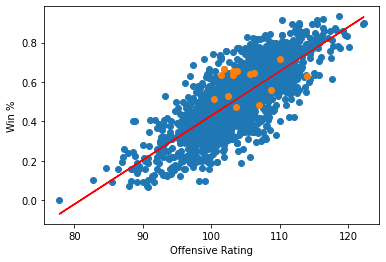

In [1035]:
recent_seasons = list(range(2018,2024))
recent_seasons.remove(2020)
# print(recent_seasons[0])
df_recent_train = df[df['Season'].isin(recent_seasons)]
# df_recent_test = df[df['Season'] == 2023]
colorado = df[df['Team'] == 'colorado']
cx = colorado['ORtg']
cy = colorado['W%']

X = df_recent['ORtg']

y = df_recent['W%']

m, b = np.polyfit(X, y, 1)
# print(m,b)


model = sm.OLS(y,X).fit()
# pred_ols = res.get_prediction()
# iv_l = pred_ols.summary_frame()["obs_ci_lower"]
# iv_u = pred_ols.summary_frame()["obs_ci_upper"]
print('R-squared: ' + str(model.rsquared))

plt.plot(X, y, 'o', label='All teams')
plt.plot(cx,cy,'o', label='CU')
plt.xlabel('Offensive Rating')
plt.ylabel('Win %')
plt.legend()
plt.plot(X, m*X+b, c='red')
plt.show()

In [1085]:
ortgs = list(df[df['TourneySeed'] == 1]['ORtg'].values)
ortgs.sort()
print(ortgs)

[106.8, 108.8, 109.1, 109.7, 110.3, 110.4, 110.4, 111.1, 111.3, 111.4, 111.5, 112.1, 112.3, 112.6, 112.7, 112.8, 112.8, 113.3, 114.0, 114.7, 115.0, 115.0, 115.2, 115.4, 115.5, 115.5, 115.5, 115.5, 115.7, 116.0, 116.0, 116.1, 116.3, 116.3, 116.3, 116.4, 116.5, 116.8, 116.9, 117.6, 118.0, 118.0, 118.1, 118.7, 119.4, 120.0, 121.1, 122.2, 122.3]


R-squared: 0.9226502795862306


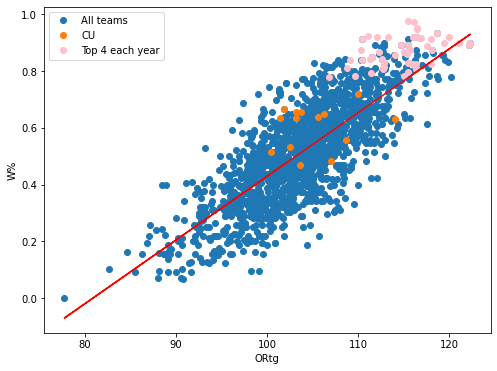

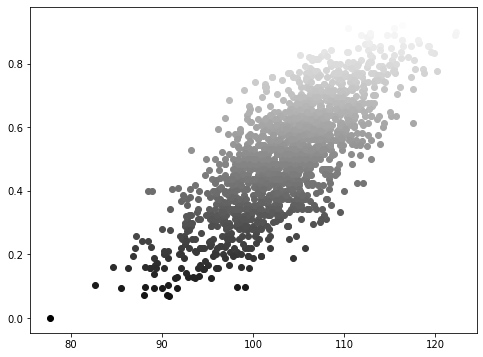

In [1040]:
makePlot(df,'ORtg','W%')

ORtg   NaN
dtype: float64


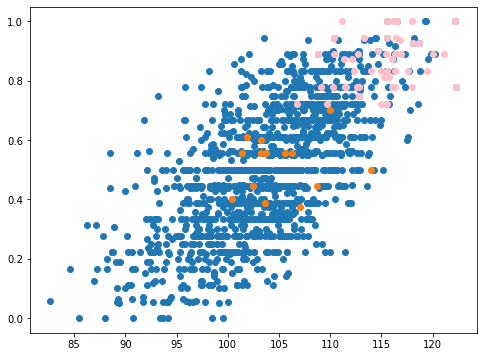

89.0, team: fairleigh dickinson 2012
102.6, team: massachusetts 2013
105.9, team: oral roberts 2013


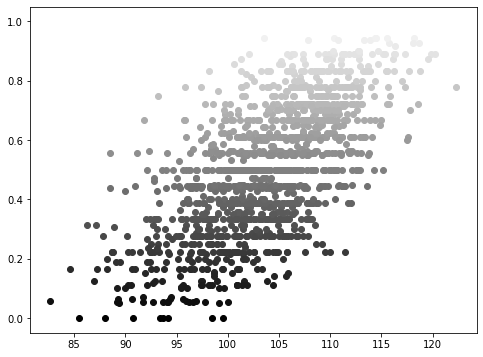

In [906]:
makePlot(df,'ORtg','cW%')

DRtg    0.004954
dtype: float64


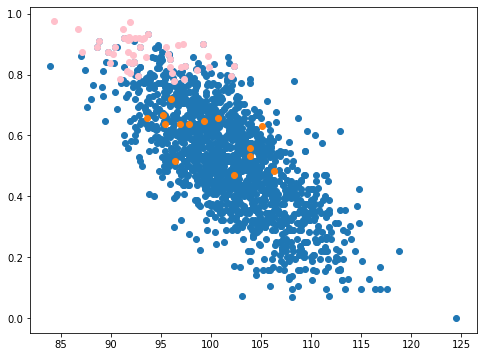

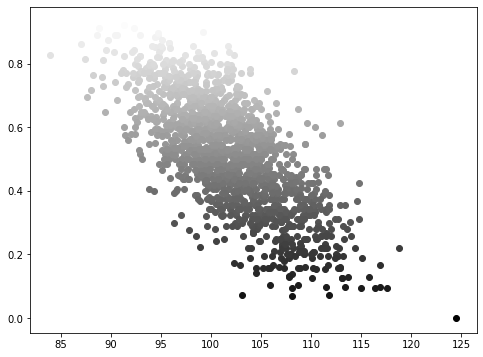

In [858]:
makePlot(df,'DRtg','W%')

R-squared: 0.8090578869428532


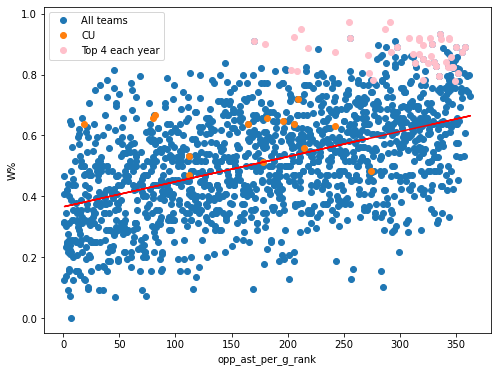

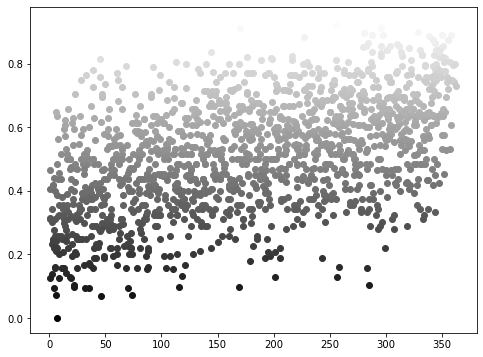

In [1057]:
makePlot(df,'opp_ast_per_g_rank','W%')

opp_drb_per_g_rank    0.001962
dtype: float64


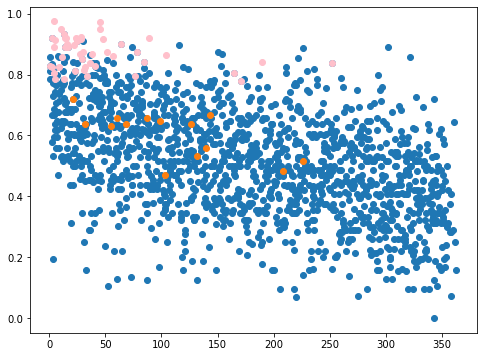

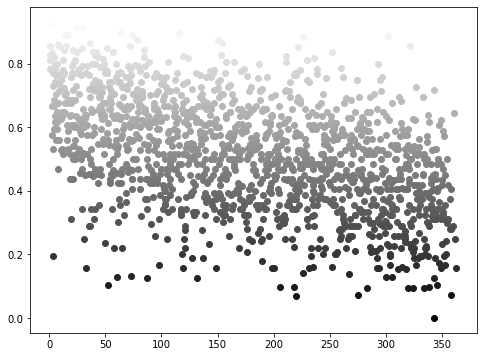

In [911]:
makePlot(df,'opp_drb_per_g_rank','W%')

stl_per_g_rank    0.00207
dtype: float64


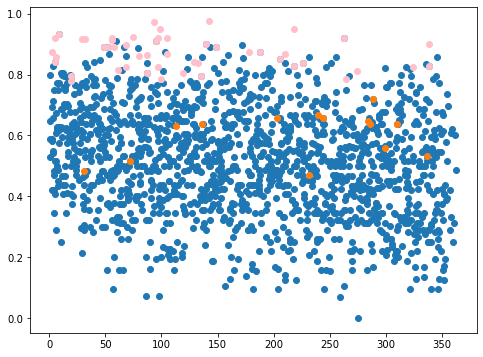

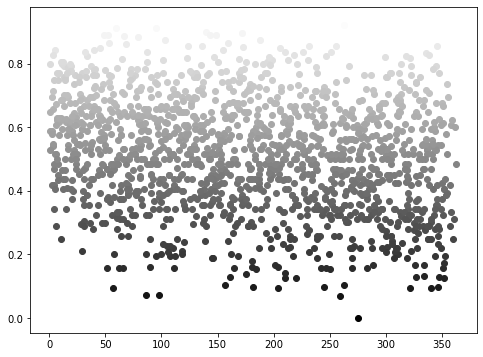

In [1020]:
makePlot(df,'stl_per_g_rank','W%')

In [827]:
def get_corrs(df,n=5):
    df_colorado = df[df['Team'] == 'colorado']
    cols = df.columns[11:-16]
    correl = {}
    for col in cols:
        correl[col] = abs(df_colorado[[col,'W%']].corr().values[0][1])
#         print('corrcoef')
#         print(np.corrcoef(df['W%'],df[col]))
#         print('corr')
#         print()
    
    topN = getTopN(correl,n)

In [828]:
get_corrs(df,8)

SRS_rank: 0.7469420292985273
SRS: 0.6953500204353715
opp_drb_per_g_rank: 0.692936281352286
pf_per_g_rank: 0.68988464262588
opp_fta_per_g_rank: 0.6859675233429077
PA/G_rank: 0.6191092532039945
DRtg_rank: 0.6011530808644211
DRtg: 0.5959036098430567


0.548759068231637


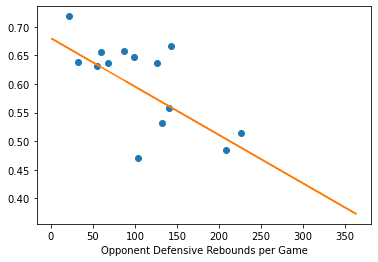

In [1051]:
colorado = df[df['Team'] == 'colorado']
cx = colorado['opp_drb_per_g_rank']
cy = colorado['W%']
# print(colorado['opp_drb_per_g_rank'])

# topTeams = df[df['TourneySeed'] == 1]
# tx = topTeams[ind]
# ty = topTeams[dep]

X = df['opp_drb_per_g_rank']
y = df['W%']

m, b = np.polyfit(X, y, 1)
# print(m,b)


model = sm.OLS(y,X).fit()
# pred_ols = res.get_prediction()
# iv_l = pred_ols.summary_frame()["obs_ci_lower"]
# iv_u = pred_ols.summary_frame()["obs_ci_upper"]
print(model.rsquared)
# print(model.params)

plt.plot(cx,cy,'o')
plt.xlabel('Opponent Defensive Rebounds per Game')
plt.plot(X, (m)*X+b+0.02)
plt.show()

52       32.0
389     209.0
733     251.0
1077    297.0
1425    335.0
1776    185.0
2127    224.0
2478    200.0
2829     88.0
3181    231.0
3534    339.0
3886    247.0
3947    250.0
4305    237.0
Name: pf_per_g_rank, dtype: float64
52      0.483871
389     0.631579
733     0.666667
1077    0.636364
1425    0.657143
1776    0.470588
2127    0.647059
2478    0.558824
2829    0.531250
3181    0.638889
3534    0.656250
3886    0.718750
3947    0.636364
4305    0.514286
Name: W%, dtype: float64
0.00045596350096262163 0.4310986236452211
R-squared: 0.7455889151960926


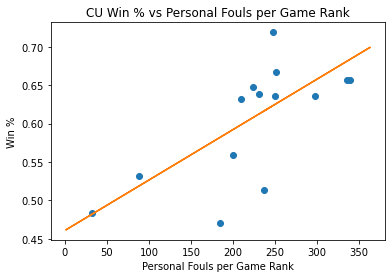

In [1238]:
colorado = df[df['Team'] == 'colorado']
cx = colorado['pf_per_g_rank']
cy = colorado['W%']
print(colorado['pf_per_g_rank'])
print(colorado['W%'])

# topTeams = df[df['TourneySeed'] == 1]
# tx = topTeams[ind]
# ty = topTeams[dep]

X = df['pf_per_g_rank']
y = df['W%']

m, b = np.polyfit(X, y, 1)
print(m,b)


model = sm.OLS(y,X).fit()
# pred_ols = res.get_prediction()
# iv_l = pred_ols.summary_frame()["obs_ci_lower"]
# iv_u = pred_ols.summary_frame()["obs_ci_upper"]
print('R-squared: ' + str(model.rsquared))

plt.plot(cx,cy,'o')
plt.xlabel('Personal Fouls per Game Rank')
plt.ylabel('Win %')
plt.title('CU Win % vs Personal Fouls per Game Rank')
plt.plot(X, (m+0.0002)*X+b+0.03)
plt.show()

pf_per_g_rank    0.002252
dtype: float64


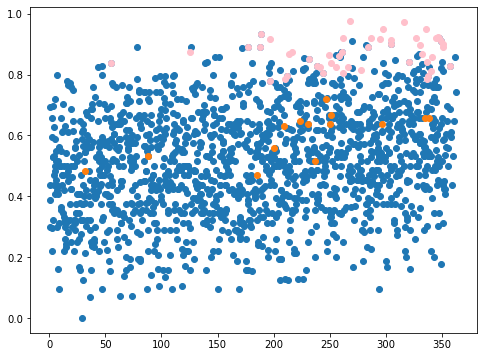

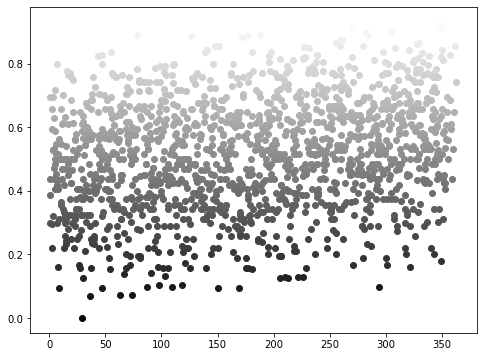

In [912]:
makePlot(df,'pf_per_g_rank','W%')

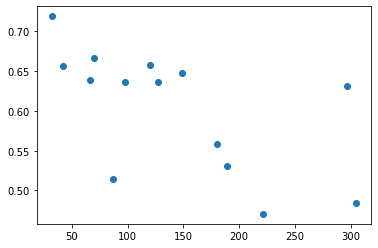

In [831]:
# PA/G_rank
colorado = df[df['Team'] == 'colorado']
cx = colorado['PA/G_rank']
cy = colorado['W%']
# print(colorado['PA/G_rank'])
# print(colorado['W%'])

# topTeams = df[df['TourneySeed'] == 1]
# tx = topTeams[ind]
# ty = topTeams[dep]

X = df['PA/G_rank']
y = df['W%']

# m, b = np.polyfit(X, y, 1)
# print(m,b)


model = sm.OLS(y,X).fit()
# pred_ols = res.get_prediction()
# iv_l = pred_ols.summary_frame()["obs_ci_lower"]
# iv_u = pred_ols.summary_frame()["obs_ci_upper"]
# print(model.rsquared)

plt.plot(cx,cy,'o')
# plt.plot(X, m*X+b)
plt.show()

PA/G_rank    0.00193
dtype: float64


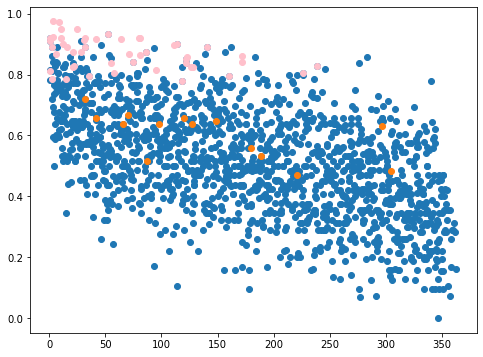

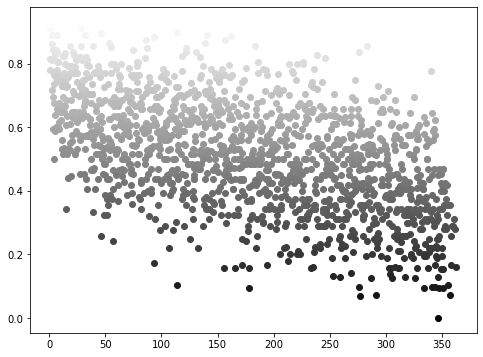

In [861]:
makePlot('PA/G_rank','W%')

In [870]:
pac12 = df[df['Conference'] == 'pac-12']
pac12.head()



,Unnamed: 0,Team,Season,Ws,Ls,W%,cWs,cLs,cW%,cStand,...,h_NCAA,h_FF,h_NC,didUpset,vsExpected,TourneySeed,wasUpset,outperformed,underperformed,asExpected
688,688,arizona state,2012,10.0,21.0,0.322581,6.0,12.0,0.333333,10.0,...,17.0,0.0,0.0,0,NaN,NaN,0,0,0,NaN
689,689,arizona,2012,23.0,12.0,0.657143,12.0,6.0,0.666667,4.0,...,37.0,4.0,1.0,0,NaN,NaN,0,0,0,NaN
716,716,california golden,2012,24.0,10.0,0.705882,13.0,5.0,0.722222,2.0,...,19.0,3.0,1.0,0,0.0,12.0,0,0,0,1.0
733,733,colorado,2012,24.0,12.0,0.666667,11.0,7.0,0.611111,5.0,...,15.0,2.0,0.0,1,0.0,11.0,0,0,0,1.0
896,896,oregon,2012,24.0,10.0,0.705882,13.0,5.0,0.722222,2.0,...,17.0,2.0,1.0,0,NaN,NaN,0,0,0,NaN


In [1015]:
def get_corrs(df,n=5):
    pac12 = df[df['Conference'] == 'pac-12']
    cols = df.columns[11:-16]
    correl = {}
    for col in cols:
        correl[col] = abs(pac12[[col,'cW%']].corr().values[0][1])
#         print('corrcoef')
#         print(np.corrcoef(df['W%'],df[col]))
#         print('corr')
#         print()
    
    topN = getTopN(correl,n)

In [1016]:
get_corrs(df,10)

SRS: 0.8476906941068385
SRS_rank: 0.8233050147854635
ORtg_rank: 0.6977015345624198
ORtg: 0.6947477766051097
DRtg_rank: 0.6532639767313695
DRtg: 0.616905466224297
PS/G_rank: 0.5890923230825372
opp_fg_pct_rank: 0.5873750142379961
fg_pct: 0.5809106833073725
fg_pct_rank: 0.5635465453810812


In [920]:
pac12 = df[df['Conference'] == 'pac-12']


In [968]:
def makePlotP12(df1,ind,dep,recently=True):
    df = df1.copy(deep=True)
    df = df.dropna(subset=[ind,dep])
    if recently:
        recent_seasons = list(range(2018,2024))
        recent_seasons.remove(2020)
        df_recent_train = df[df['Season'].isin(recent_seasons)]
    
    colorado = df[df['Team'] == 'colorado']
    cx = colorado[ind]
    cy = colorado[dep]

    topTeams = df[(df['cStand'] == 1) | (df['cStand'] == 2)]
#     topTeams = df[(df['cStand'] == 1)]
    print(len(topTeams))
    tx = topTeams[ind]
    ty = topTeams[dep]

    if recently:
        X = df_recent[ind]
        y = df_recent[dep]
    else:
        X = df[ind]
        y = df[dep]

    # m, b = np.polyfit(X, y, 1)
    # print(m,b)


    model = sm.OLS(y,X).fit()
    # pred_ols = res.get_prediction()
    # iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    # iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    print(model.params)
#     color = [str(item/255.) for item in y]
    
    print(len(df))
    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(X, y, 'o')
    plt.plot(cx,cy,'o')
    plt.plot(tx,ty,'o', color='pink')
    plt.show()
    
#     # plots gray gradient plot
#     fig, ax = plt.subplots(figsize=(8,6))
#     for i in range(len(X)):
# #         print(y.iloc[i])
#         c = str(y.iloc[i]/max(y))
#         plt.plot(X.iloc[i], y.iloc[i],  'o', color=c)
# #     plt.plot(cx,cy,'o')
# #     plt.plot(tx,ty,'o', color='pink')
#     plt.show()
#     # plt.plot(X, m*X+b)

#### There is a high correlation between fg pct and finishing at the top of the pac-12

R-squared: 0.9387614769952121


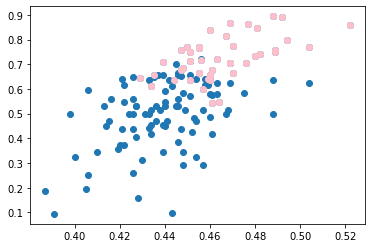

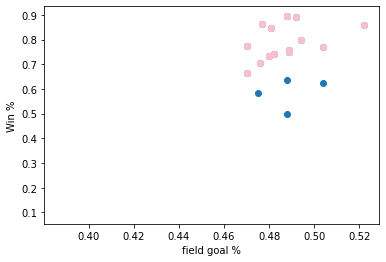

0.29
0.78


In [1131]:
model = sm.OLS(pac12['W%'],pac12['fg_pct']).fit()
print('R-squared: ' + str(model.rsquared))

# makePlotP12(pac12,'opp_fg_pct_rank','W%')
topPac = pac12[(pac12['cStand'] <= 3)]
plt.plot(pac12['fg_pct'],pac12['W%'],'o')
plt.plot(topPac['fg_pct'],topPac['W%'],'o', color='pink')
plt.xlabel('')
plt.show()

# ax,fig = plt.subplots()
tpac = pac12[(pac12['fg_pct'] >= 0.47)]
tpacTop = tpac[(tpac['cStand'] <= 3)]
tpacB = tpac[(tpac['cStand'] > 3)]
plt.plot(pac12['fg_pct'],pac12['W%'],'o',color='white')
plt.plot(tpac['fg_pct'],tpac['W%'],'o')
plt.plot(tpacTop['fg_pct'],tpacTop['W%'],'o', color='pink')
plt.xlabel('field goal %')
plt.ylabel('Win %')
plt.show()

tpacT_len = len(tpacTop)
tpacB_len = len(tpacB)
print(round(tpacB_len/(len(colorado)),2))
print(round(tpacT_len/(tpacT_len+tpacB_len),2))

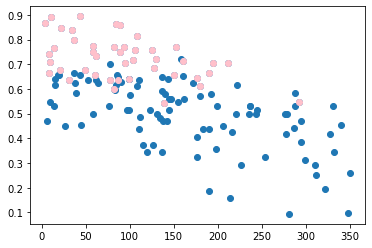

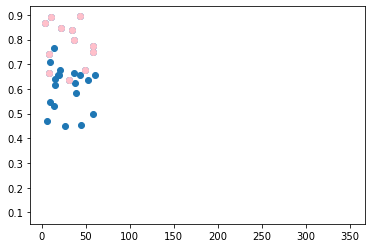

15
0.44


In [1012]:
# opp_fg_pct_rank
# makePlotP12(pac12,'opp_fg_pct_rank','W%')
topPac = pac12[(pac12['cStand'] <= 3)]
plt.plot(pac12['opp_fg_pct_rank'],pac12['W%'],'o')
plt.plot(topPac['opp_fg_pct_rank'],topPac['W%'],'o', color='pink')
plt.show()

# ax,fig = plt.subplots()
tpac = pac12[(pac12['opp_fg_pct_rank'] <= 60)]
tpacTop = tpac[(tpac['cStand'] <= 2)]
tpacB = tpac[(tpac['cStand'] > 3)]
plt.plot(pac12['opp_fg_pct_rank'],pac12['W%'],'o',color='white')
plt.plot(tpac['opp_fg_pct_rank'],tpac['W%'],'o')
plt.plot(tpacTop['opp_fg_pct_rank'],tpacTop['W%'],'o', color='pink')
plt.show()

tpacT_len = len(tpacTop)
tpacB_len = len(tpacB)
print(tpacB_len)
print(round(tpacT_len/(tpacT_len+tpacB_len),2))

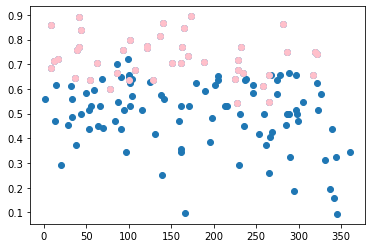

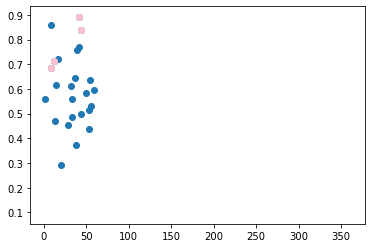

18
0.18


In [1014]:
# opp_fg_pct_rank
# makePlotP12(pac12,'opp_fg_pct_rank','W%')
topPac = pac12[(pac12['cStand'] <= 3)]
plt.plot(pac12['fga_per_g_rank'],pac12['W%'],'o')
plt.plot(topPac['fga_per_g_rank'],topPac['W%'],'o', color='pink')
plt.show()

# ax,fig = plt.subplots()
tpac = pac12[(pac12['fga_per_g_rank'] <= 60)]
tpacTop = tpac[(tpac['cStand'] <= )]
tpacB = tpac[(tpac['cStand'] > 3)]
plt.plot(pac12['fga_per_g_rank'],pac12['W%'],'o',color='white')
plt.plot(tpac['fga_per_g_rank'],tpac['W%'],'o')
plt.plot(tpacTop['fga_per_g_rank'],tpacTop['W%'],'o', color='pink')
plt.show()

tpacT_len = len(tpacTop)
tpacB_len = len(tpacB)
print(tpacB_len)
print(round(tpacT_len/(tpacT_len+tpacB_len),2))

In [1134]:
def getMus(newddf,k,ind,dep):
    mus = newdf.loc[:,[ind,dep]].sample(n=k)
#     print(mus.values)
    while(not mus_spread(mus,k)):
        mus = []
        mus = newdf.loc[:,[ind,dep]].sample(n=k)
    
    return mus

def dist(x,y):
#     print(x,y)
    return np.sqrt((x[ind] - y[ind])**2 + (x[dep] - y[dep])**2)

def mus_spread(mus,k):
    dists = []
    for i in range(k):
        for j in range(i+1,k):
            if dist(mus.iloc[i],mus.iloc[j]) < (2/k):
                return False
    
    return True

ind = 'W%'
dep = 'ast_per_g'
mus = newdf.loc[:,[ind,dep]].sample(n=4)
while(not mus_spread(mus,4)):
    mus = []
    mus = newdf.loc[:,[ind,dep]].sample(n=4)


print(mus)

            W%  ast_per_g
1427  0.613937  -0.447080
467   0.948935   0.449877
488  -1.834376  -1.904636
1534 -0.889948  -0.615260


In [1142]:
def dis(x,y):
    dis = 0
    for i in range(len(x)):
        dis += (x[0]-y[0])**2
    dis = np.sqrt(dis)
    return dis

def checkms(ms, prevms):
    if len(prevms) == 0:
        return True
#     dis = lambda x,y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    
    totalDist = 0
    enter = False
    for i in range(len(prevms)):
        totalDist += dis(ms[i],prevms[i])
        enter=True
        
    if totalDist < len(ms)/50:
        return False
    
    return True
            
    

def mus_spread(mus,k):
    dists = []
    for i in range(k):
        for j in range(i+1,k):
            if dist(mus.iloc[i],mus.iloc[j]) < (20/k):
                return False
    
    return True

        


def expectations(dat,k,mus,covs,ws,ind,dep):
    data = dat.loc[:,[ind,dep]]
    vals = data.values
#     print(vals)
    pdfs = [stats.multivariate_normal.pdf(vals, mean=mus[m], cov=covs[m]) for m in range(len(mus))]
    clusts = [[] for _ in range(k)]
    dists = []
    hard_clust = []
    weights = np.zeros(shape=k)
    for i in range(len(data)):
        ps = []
        for m in range(k):
            p = pdfs[m][i]*ws[m]
            ps.append(p)

        ps = ps/(np.sum(ps))
        print('np.sum(ps): ' + str(np.sum(ps)))
        if np.sum(ps) < 0.9 or np.sum(ps) > 1.01:
            print("ERROR: sum of rows incorrect: ", np.sum(ps))
            
        
        # This is just for part C, not an idiot hard clustering in EM Algo
        idx = list(ps).index(max(ps))
        hard_clust.append(idx)
#         print(idx)
        
        dists.append(ps)
    
    for i in range(k):
        for j in range(len(dists)):
            weights[i] += dists[j][i]
    
    
#     print(hard_clust)
    return dists,clusts,weights,pdfs,hard_clust



def maximization(dat, dists, clusts, weights,ind,dep):
    data = dat.loc[:,[ind,dep]]
#     data = dat.loc[:,dat.columns]
    mus = []
    covs = []
    for i in range(len(clusts)):
        mu_x = [0]*len(dat.columns)
        for j in range(len(data)):
#             for k in range(len(2)):
#                 mu_x[k] += dists[j][i]*data.iloc[j][dat.columns[k]]
            mu_x[0] += dists[j][i]*data.iloc[j][ind]
            mu_x[1] += dists[j][i]*data.iloc[j][dep]
#             mu_x[1] += dists[j][i]*data.iloc[j]['FPos']
        
        mu = list([(1/weights[i])*(mu_x[0]), (1/weights[i])*(mu_x[1])])
        mus.append(mu)
        
#     print(data.values.shape,len(mus))
    for i in range(len(clusts)):
        var_x = [[0,0],[0,0]]
        for j in range(len(data)):
            
            vall = np.matrix(data.values[j] - mus[i])
            vale = vall.T
            var_x += dists[j][i]*np.matmul(vale,vall)
#             var_x += dists[j][i]*(data.values[j] - mus[i])*(data.values[j] - mus[i])
        
        cov = var_x/weights[i]
        covs.append(cov)
    
    return mus, covs
        


def GMM(dat,k,mus,ind,dep):
    df = dat.copy(deep=True)
    ms = mus.values
    weights=[1/k]*k
    cov = [np.cov(df[ind],df[dep])]*k
#     cov = np.cov(newdf)
#     print(cov.shape)
    dists, clusters, weights, pdfs, hardclust = expectations(dat,k,ms,cov, weights)
    ms, covs = maximization(dat,dists,clusters,weights)
    i=0
    prevms = []
    while i < 2 and checkms(ms,prevms):
        prevms = ms
        dists, clusters, weights, pdfs, hardclusts = expectations(dat,k,ms,covs, weights)
        ms, covs = maximization(dat,dists,clusters,weights)
        i+= 1
        
    print("Iterations:",i)
    
    return ms,covs,(weights/len(dat)),dists,hardclusts,pdfs
        

In [1204]:
def makePlotCUTop(df1,ind,dep,label_map={},recently=True):
    df = df1.copy(deep=True)
    df = df.dropna(subset=[ind,dep])
    if recently:
        recent_seasons = list(range(2018,2024))
        recent_seasons.remove(2020)
        df_recent_train = df[df['Season'].isin(recent_seasons)]
    
    colorado = df[df['Team'] == 'colorado']
    cx = colorado[ind]
    cy = colorado[dep]

    topTeams = df[df['TourneySeed'] == 1]
    tx = topTeams[ind]
    ty = topTeams[dep]
    
#     lim = 12.3
    lim = 14
    print(round(len(topTeams[topTeams[ind] >= lim])/len(topTeams),2))
    print(round(len(colorado[colorado[ind] >= lim])/len(colorado),2))

    if recently:
        X = df_recent[ind]
        y = df_recent[dep]
    else:
        X = df[ind]
        y = df[dep]

    m, b = np.polyfit(X, y, 1)
    # print(m,b)

    m, b = np.polyfit(X, y, 1)

    model = sm.OLS(y,X).fit()
    # pred_ols = res.get_prediction()
    # iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    # iv_u = pred_ols.summary_frame()["obs_ci_upper"]
#     print(model.params)
#     color = [str(item/255.) for item in y]
    print('R-squared: ' + str(model.rsquared))
    
    fig, ax = plt.subplots(figsize=(8,6))
#     plt.plot(X, y, 'o', label='All teams')
    plt.axvline(x = lim, color='red')
    plt.plot(cx,cy,'o', label='CU')
    plt.plot(tx,ty,'o', color='pink', label='Top 4 each year')
#     plt.plot(X, m*X+b, c='red')
    plt.xlabel(label_map[ind])
    plt.ylabel(label_map[dep])
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,6))
#     plt.plot(X, y, 'o', label='All teams')
#     plt.axvline(x = lim, color='red')
    plt.plot(cx,cy,'o', label='CU')
    plt.plot(tx,ty,'o', color='pink', label='Top 4 each year')
#     plt.plot(X, m*X+b, c='red')
    plt.xlabel(label_map[ind])
    plt.ylabel(label_map[dep])
    plt.plot(cx.mean(), cy.mean(), 'o', label='CU Mean')
    plt.plot(tx.mean(), ty.mean(), 'o', label='Top 4 Mean')
    
    mixDf = df[(df['Team'] == 'colorado') | (df['TourneySeed'] == 1)]
    X_train = mixDf[[ind,dep]]
    plt.plot()
    clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
    clf.fit(X_train)
    x = np.linspace(8.0, 20.0)
    y = np.linspace(0, 1.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(
        X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
    )
    
    plt.legend()
    plt.show()

0.84
0.07
R-squared: 0.9233148124752948


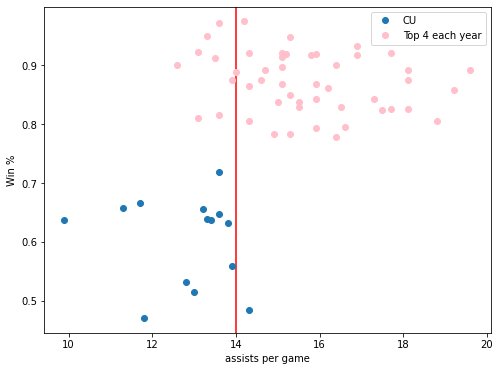

C:\Users\bhean\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\4287271013.py:76: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(


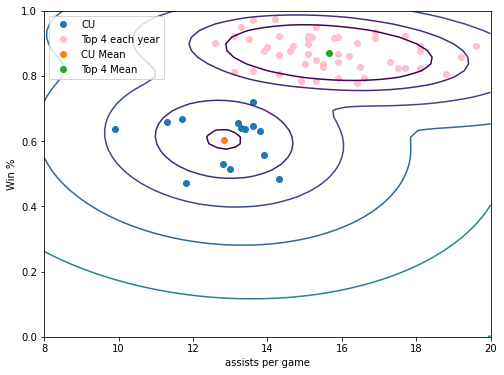

In [1207]:
makePlotCUTop(df,'ast_per_g','W%',{'ast_per_g': 'assists per game', 'W%': 'Win %'})

In [1535]:
def makePlotCUTop(df1,ind,dep,label_map={},recently=True):
    df = df1.copy(deep=True)
    df = df.dropna(subset=[ind,dep])
    if recently:
        recent_seasons = list(range(2018,2024))
        recent_seasons.remove(2020)
        df_recent_train = df[df['Season'].isin(recent_seasons)]
    
    colorado = df[df['Team'] == 'colorado']
    cx = colorado[ind]
    cy = colorado[dep]

    topTeams = df[df['TourneySeed'] == 1]
    tx = topTeams[ind]
    ty = topTeams[dep]
    
#     lim = 12.3
    lim = 14
    print(round(len(topTeams[topTeams[ind] >= lim])/len(topTeams),2))
    print(round(len(colorado[colorado[ind] >= lim])/len(colorado),2))

    if recently:
        X = df_recent[ind]
        y = df_recent[dep]
    else:
        X = df[ind]
        y = df[dep]

    m, b = np.polyfit(X, y, 1)
    # print(m,b)

    m, b = np.polyfit(X, y, 1)

    model = sm.OLS(y,X).fit()
    # pred_ols = res.get_prediction()
    # iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    # iv_u = pred_ols.summary_frame()["obs_ci_upper"]
#     print(model.params)
#     color = [str(item/255.) for item in y]
    print('R-squared: ' + str(model.rsquared))
    
    fig, ax = plt.subplots(figsize=(8,6))
#     plt.plot(X, y, 'o', label='All teams')
    plt.axvline(x = lim, color='red')
    plt.plot(cx,cy,'o', label='CU')
    plt.plot(tx,ty,'o', color='pink', label='Top 4 each year')
#     plt.plot(X, m*X+b, c='red')
    plt.xlabel(label_map[ind])
    plt.ylabel(label_map[dep])
    plt.legend()
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,6))
#     plt.plot(X, y, 'o', label='All teams')
#     plt.axvline(x = lim, color='red')
    plt.plot(cx,cy,'o', label='CU')
    plt.plot(tx,ty,'o', color='pink', label='Top 4 each year')
#     plt.plot(X, m*X+b, c='red')
    plt.xlabel(label_map[ind])
    plt.ylabel(label_map[dep])
    plt.plot(cx.mean(), cy.mean(), 'o', label='CU Mean')
    plt.plot(tx.mean(), ty.mean(), 'o', label='Top 4 Mean')
    
    mixDf = df[(df['Team'] == 'colorado') | (df['TourneySeed'] == 1)]
    X_train = mixDf[[ind,dep]]
    plt.plot()
    clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
    clf.fit(X_train)
    x = np.linspace(8.0, 20.0)
    y = np.linspace(0.3, 1.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(
        X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 2, 15)
    )
    
    plt.legend()
    plt.show()

0.84
0.07
R-squared: 0.9233148124752948


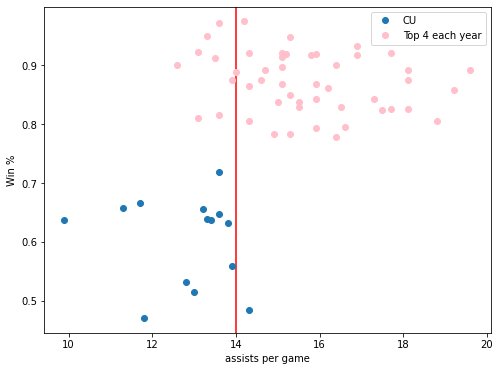

C:\Users\bhean\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\bhean\AppData\Local\Temp\ipykernel_12420\483461949.py:76: UserWarning: Log scale: values of z <= 0 have been masked
  CS = plt.contour(


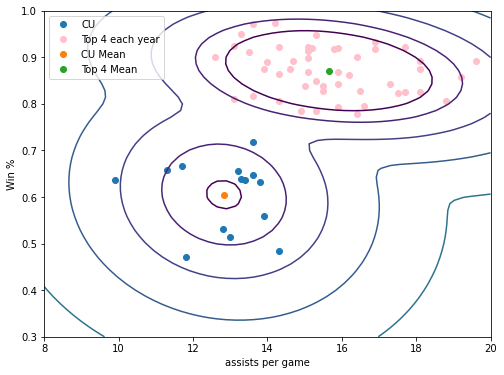

In [1534]:
makePlotCUTop(df,'ast_per_g','W%',{'ast_per_g': 'assists per game', 'W%': 'Win %'})

In [1147]:
list(df[[ind,dep]].mean())

[0.5113004378604098, 13.097505963999167]

R-squared: 0.9387614769952121


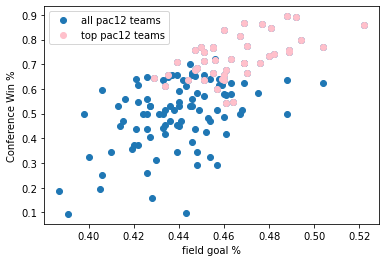

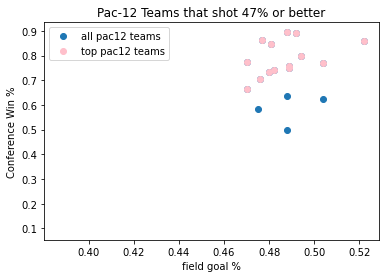

0.29
0.78


In [1260]:
model = sm.OLS(pac12['W%'],pac12['fg_pct']).fit()
print('R-squared: ' + str(model.rsquared))

# makePlotP12(pac12,'opp_fg_pct_rank','W%')
topPac = pac12[(pac12['cStand'] <= 3)]
plt.plot(pac12['fg_pct'],pac12['W%'],'o', label='all pac12 teams')
plt.plot(topPac['fg_pct'],topPac['W%'],'o', color='pink', label='top pac12 teams')
plt.xlabel('field goal %')
plt.ylabel('Conference Win %')
plt.legend()
plt.show()

# ax,fig = plt.subplots()
tpac = pac12[(pac12['fg_pct'] >= 0.47)]
tpacTop = tpac[(tpac['cStand'] <= 3)]
tpacB = tpac[(tpac['cStand'] > 3)]
plt.plot(pac12['fg_pct'],pac12['W%'],'o',color='white')
plt.plot(tpac['fg_pct'],tpac['W%'],'o', label='all pac12 teams')
plt.plot(tpacTop['fg_pct'],tpacTop['W%'],'o', color='pink', label='top pac12 teams')
plt.xlabel('field goal %')
plt.ylabel('Conference Win %')
plt.title('Pac-12 Teams that shot 47% or better')
plt.legend()
plt.show()

# pacLow = pac12[(pac12['cStand'] <= 3)]
# pacTop = pac12[(pac12['cStand'] > 3)]
# plt.plot(pac12['fg_pct'],pac12['W%'],'o')
# plt.plot(topPac['fg_pct'],topPac['W%'],'o', color='pink')
# plt.xlabel('field goal %')
# ind = 'fg_pct'
# dep = 'W%'
# label_map = {'ast_per_g': 'assists per game', 'W%': 'Win %'}
# X_train = pac12[[ind,dep]]
# plt.plot()
# clf = mixture.GaussianMixture(n_components=2, covariance_type="full")
# clf.fit(X_train)
# x = np.linspace(0.38, 0.54)
# y = np.linspace(0, 1.0)
# X, Y = np.meshgrid(x, y)
# XX = np.array([X.ravel(), Y.ravel()]).T
# Z = -clf.score_samples(XX)
# Z = Z.reshape(X.shape)

# CS = plt.contour(
#     X, Y, Z, norm=LogNorm(vmin=0.1, vmax=1000.0), levels=np.logspace(0, 5, 100)
# )

# plt.legend()
# plt.show()

tpacT_len = len(tpacTop)
tpacB_len = len(tpacB)
print(round(tpacB_len/(len(colorado)),2))
print(round(tpacT_len/(tpacT_len+tpacB_len),2))

In [1362]:
def getRankOrValue(df, stat, rank=None, value=None, isRank=False):
    if isRank:
        indx = stat.replace('_rank', '')
#         print(indx)
        stat_lst = list(df[indx].values)
#         print(len(stat_lst))
        stat_lst.sort(reverse=True)
#         print(stat_lst[300])
        return float(stat_lst[rank])
    else:
        indx = stat + str('_rank')
        val_lst = list(df[stat].values)
        val_lst.sort(reverse=True)
        val_to_rank = [value,value]
        while not (val_to_rank[0] in val_lst) and (val_to_rank[1] in val_lst):
            val_to_rank[0] += 0.1
            val_to_rank[1] -= 0.1
            if val_to_rank[0] in val_lst:
                value = val_to_rank[0]
            elif val_to_rank[1] in val_lst:
                value = val_to_rank[1]
            
        ranking = df[df[stat] == value][indx].values.mean()
        return float(int(ranking))
    
    
df23 = df[df['Season'] == 2023].copy()
df23 = drops(df23)
fifteen_point_five = getRankOrValue(df23,'pf_per_g_rank', rank=300, isRank=True)
print(fifteen_point_five)
ast = getRankOrValue(df23,'ast_per_g', value=14)
print(ast)

15.5
107.0


In [1498]:
# df_test = df.copy(deep=True)
df_train = df.copy(deep=True)
df_train_set = drops(df_train)
df_train_set = df_train_set.dropna()
cu_index = df[(df['Team'] == 'colorado') & (df['Season'] == 2023)].index
df23 = df[df['Season'] == 2023].copy()
df23 = drops(df23)
# df_test.iloc[cu_index]
df_cugoal = {}
toSkip = ['W%', 'cWs', 'cLs', 'cW%', 'cStand']
df_train_targets = df_train_set[toSkip]
df_train_set = df_train_set.drop(columns=toSkip)
df_cu = df.iloc[cu_index]
for col in df_cu.columns.values:
    if not col in toSkip:
        df_cugoal[col] = df_cu[col].values[0]
    

#have to also change the ranks of the stats
#making recommended changes
#then build a model that predicts their win %, made tourney, cW%, TourneySeed, cStand
df_cugoal['ORtg'] = 108.8
df_cugoal['ORtg_rank'] = getRankOrValue(df23,'ORtg',value=108.8)
df_cugoal['ast_per_g'] = 14.0
df_cugoal['ast_per_g_rank'] = getRankOrValue(df23,'ast_per_g',value=14)
df_cugoal['pf_per_g_rank'] = 300.0
df_cugoal['pf_per_g'] = getRankOrValue(df23,'pf_per_g_rank', rank=300, isRank=True)
df_cugoal['fg_pct'] = 0.47
df_cugoal['fg_pct_rank'] = getRankOrValue(df23,'fg_pct',value=0.47)
# print(df_cugoal)
# cuDf = pd.DataFrame.from_dict(df_cugoal)
cuDf = pd.DataFrame([df_cugoal])
cuDf = drops(cuDf)
num_games = 35



# # df_test.loc[cu_index,'ORtg'] = 108.8
# # df_test.loc[cu_index,'ast_per_g'] = 14
# # df_test.loc[cu_index,'pf_per_g_rank'] = 300

# # df_test.iloc[cu_index]
# # df_test.tail()
# cuDf
# df_cu

In [1499]:
from sklearn.linear_model import Lasso, Ridge


lasso = Lasso()
lasso.fit(df_train_set, df_train_targets['W%'])
l_pred_Wpct = lasso.predict(cuDf)[0]
print(l_pred_Wpct)

lasso.fit(df_train_set, df_train_targets['cW%'])
l_pred_cWpct = lasso.predict(cuDf)[0]
print(l_pred_cWpct)

# df_p12_23

0.721982262563931
0.6871878712048396


In [1500]:
cuDf['W%'] = l_pred_Wpct
cuDf['Ws'] = round(l_pred_Wpct*35,0)
cuDf['Ls'] = 35-cuDf['Ws']
cuDf['W%'] = cuDf['Ws']/(cuDf['Ls']+cuDf['Ws'])
cuDf['cW%'] = l_pred_cWpct
cuDf['cWs'] = round(l_pred_cWpct*20,0)
cuDf['cLs'] = 20-cuDf['cWs']
cuDf['cW%'] = cuDf['cWs']/(cuDf['cLs']+cuDf['cWs'])


# df_p12_23 = df[(df['Season'] == 2023) & (df['Conference'] == 'pac-12')]
# cStands = df_p12_23[df_p12_23['cW%'] >= float(cuDf['cW%'])]
cuDf['cStand'] = 3
cuDf[toSkip]

,W%,cWs,cLs,cW%,cStand
0,0.714286,14.0,6.0,0.7,3


In [1501]:
def dropsExcept(df, notDrop):
    cols = list(df.columns.copy().values)
    lr_cols = copy.deepcopy(cols)
    cols_to_remove = ['Team','Season','vsExpected','Conference']
    for col in cols_to_remove:
        lr_cols.remove(col)

    new_cols = copy.deepcopy(lr_cols)
    new_cols.remove('Unnamed: 0')
    new_cols.remove('asExpected')
    new_cols.remove('underperformed')
    new_cols.remove('outperformed')
    new_cols.remove('wasUpset')
    new_cols.remove('didUpset')
    new_cols.remove('Unnamed: 82')
    new_cols.remove('madeTourney')
    new_cols.remove('TourneySeed')
    new_cols.remove('Ls')
    new_cols.remove('Ws')
    new_cols.remove('h_AP')
    new_cols.remove('h_CREG')
    new_cols.remove('h_CTRN')
    new_cols.remove('h_FF')
    new_cols.remove('h_NC')
    new_cols.remove('h_NCAA')
    new_cols.remove('h_W-L%')
    for col in notDrop:
        new_cols.append(col)

    df = df[new_cols]
    return df

In [1502]:
dfTrain1 = df.copy(deep=True)
dfTrain1 = dropsExcept(df_train, ['madeTourney','Ws','Ls'])
dfTrain1 = dfTrain1.dropna()
dfTrainLabels = copy.deepcopy(dfTrain1['madeTourney'])
dfTrain1 = dfTrain1.drop(columns=['madeTourney'])
print(len(dfTrain1.columns))
print(cuDf.columns)
lasso = Lasso()
lasso.fit(dfTrain1, dfTrainLabels)
l_pred_Tseed = lasso.predict(cuDf)[0]
print(l_pred_Tseed)

77
Index(['PS/G', 'PS/G_rank', 'PA/G', 'PA/G_rank', 'SRS', 'SRS_rank', 'SOS',
       'SOS_rank', 'ORtg', 'ORtg_rank', 'DRtg', 'DRtg_rank', 'AvgClass',
       'AvgHeight', 'fga_per_g', 'fga_per_g_rank', 'fg_pct', 'fg_pct_rank',
       'fg2a_per_g', 'fg2a_per_g_rank', 'fg3a_per_g', 'fg3a_per_g_rank',
       'fg3_pct', 'fg3_pct_rank', 'fta_per_g', 'fta_per_g_rank', 'ft_pct',
       'ft_pct_rank', 'orb_per_g', 'orb_per_g_rank', 'drb_per_g',
       'drb_per_g_rank', 'ast_per_g', 'ast_per_g_rank', 'stl_per_g',
       'stl_per_g_rank', 'blk_per_g', 'blk_per_g_rank', 'tov_per_g',
       'tov_per_g_rank', 'pf_per_g', 'pf_per_g_rank', 'opp_fga_per_g',
       'opp_fga_per_g_rank', 'opp_fg_pct', 'opp_fg_pct_rank', 'opp_fg2a_per_g',
       'opp_fg2a_per_g_rank', 'opp_fg3a_per_g', 'opp_fg3a_per_g_rank',
       'opp_fg3_pct', 'opp_fg3_pct_rank', 'opp_fta_per_g',
       'opp_fta_per_g_rank', 'opp_ft_pct', 'opp_ft_pct_rank', 'opp_orb_per_g',
       'opp_orb_per_g_rank', 'opp_drb_per_g', 'opp_drb_per_g_

C:\Users\bhean\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [1503]:
updatedCols = toSkip.copy()
updatedCols.append('Ws')
updatedCols.append('Ls')
df_cu[updatedCols]

,W%,cWs,cLs,cW%,cStand,Ws,Ls
4305,0.514286,8.0,12.0,0.4,8.0,18.0,17.0


In [1504]:
cuDf[updatedCols]

,W%,cWs,cLs,cW%,cStand,Ws,Ls
0,0.714286,14.0,6.0,0.7,3,25.0,10.0


In [1514]:
dfTrain1 = df.copy(deep=True)
dfTrain1 = dropsExcept(df_train, ['TourneySeed','Ws','Ls'])
dfTrain1 = dfTrain1.dropna()
dfTrainLabels = copy.deepcopy(dfTrain1['TourneySeed'])
dfTrain1 = dfTrain1.drop(columns=['TourneySeed'])
# print(len(dfTrain1.columns))
# print(cuDf.columns)
lasso = Lasso()
lasso.fit(dfTrain1, dfTrainLabels)
l_pred_Tseed = lasso.predict(cuDf)[0]
print(l_pred_Tseed)
df['TourneySeed']

-14.098411171464054


C:\Users\bhean\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
4606    NaN
4607    NaN
4608    3.0
4609    NaN
4610    NaN
Name: TourneySeed, Length: 4611, dtype: float64

In [1524]:
print(str(df_cu['ORtg'].values[0]) + ' -> 108.8')
print(str(df_cu['ast_per_g'].values[0]) + ' -> 14')
print(str(df_cu['pf_per_g_rank'].values[0]) + ' -> 300')
print(df_cu['fg_pct'].values[0])
print(df_cugoal['pf_per_g'])
print(df_cu['pf_per_g'].values[0])

100.4 -> 108.8
13.0 -> 14
237.0 -> 300
0.434
15.5
16.2
